In [20]:
import os
from bson.json_util import dumps
from path import *
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


### Utils

In [21]:
def convert_from_list_to_dict(list):
    dict = {}
    for el in list:
        dict[el[0]] = int(el[1])
    return dict 

### Generatore di WordCloud

In [5]:
def generate_wordcloud(counter):
	pink_mask = np.array(Image.open(MASK_PATH))
	wc = WordCloud(width = 800, height = 800, background_color='white', mask=pink_mask).generate_from_frequencies(counter)
	image_colors = ImageColorGenerator(pink_mask)
	wc.recolor(color_func = image_colors) 
	plt.figure(figsize = (8, 8), facecolor = "black")
	plt.imshow(wc)
	plt.axis("off")
	plt.show()

#### Generatore di EmojiCloud

In [6]:
def generate_emojicloud(counter):
	pink_mask = np.array(Image.open(MASK_PATH))
	wc = WordCloud(width = 800, height = 800, background_color='white', font_path = "Symbola.otf", mask=pink_mask).generate_from_frequencies(counter )
	image_colors = ImageColorGenerator(pink_mask)
	wc.recolor(color_func = image_colors) 
	plt.figure(figsize = (8, 8), facecolor = "black")
	plt.imshow(wc)
	plt.axis("off")
	plt.show()

### MongoDB
Goal 1: per creare le word clouds per ciascun sentimento, per ciascun sentiment file,
usare la aggregation pipeline e calcolare la frequenza totale nei messaggi Twitter di ciascun token: word, hashtag, emoji, emoticon

Goal 2: calcolare le statistiche (percentuali) delle parole delle risorse lessicali presenti anche nei messaggi di Twitter

### Relazionale
1. list the lexical resources containing each word, so that
we can rely upon a unique resource source obtained by
the fusion of the single resources.
2. count the number of occurrences of each word in the
Twitter messages for each emotion so that at the end we
can draw a word cloud associated to the most frequent
words in each emotion.

In [5]:
import mysql.connector

### Connection

In [6]:
PW = 'root'

def create_db_connection(host_name, user_name, user_password, db_name):
	connection = mysql.connector.connect(
		host=host_name,
		user=user_name,
		passwd=user_password,
		database=db_name
	)
	return connection

CONNECTION = create_db_connection("localhost", "root", PW, 'maadb_project')

#### Utils

In [43]:
COLORMAP = {
	"anger": "mediumvioletred",
	"anticipation": "orange",
	"disgust": "violet",
	"fear": "forestgreen",
	"joy": "yellow",
	"sadness": "darkviolet",
	"surprise": "mediumaquamarine",
	"trust": "yellowgreen"
}

### Query

In [2]:
def get_data_from_db(query):
    cursor = CONNECTION.cursor()
    cursor.execute(query)
    return cursor

def get_sentiment():
    return get_data_from_db("SELECT * FROM sentiment;")
  
def get_words_and_frequency(sentiment, num_words):
    return get_data_from_db(f"""SELECT lemma, sum(frequence) AS occurrences
                                        FROM (
                                            SELECT *
                                            FROM wordsintweet
                                            WHERE wordsintweet.id_tweet IN (
                                                SELECT id_tweet
                                                FROM tweet
                                                WHERE sentiment = '{sentiment}'
                                            )
                                        ) AS boh JOIN word ON word.id_word = boh.id_word
                                        GROUP BY lemma
                                        ORDER BY occurrences DESC
                                        limit {num_words}""")

def get_tokens_and_frequency(sentiment, num_tokens):
    return get_data_from_db(f"""SELECT token, sum(frequence) AS occurrences
                                        FROM (
                                            SELECT *
                                            FROM tokensintweet
                                            WHERE tokensintweet.id_tweet IN (
                                                SELECT id_tweet
                                                FROM tweet
                                                WHERE sentiment = '{sentiment}'
                                            )
                                        ) AS boh JOIN token ON token.id_token = boh.id_token
                                        GROUP BY token
                                        ORDER BY occurrences DESC
                                        limit {num_tokens}""")

In [12]:
anger_data = get_words_and_frequency("anger", 50).fetchall()
#anticipation_data = get_words_and_frequency("anticipation", 50).fetchall()
#disgust_data = get_words_and_frequency("disgust", 50).fetchall()
#fear_data = get_words_and_frequency("fear", 50).fetchall()
#joy_data = get_words_and_frequency("joy", 50).fetchall()
#sadness_data = get_words_and_frequency("sadness", 50).fetchall()
#surprise_data = get_words_and_frequency("surprise", 50).fetchall()
#trust_data = get_words_and_frequency("trust", 50).fetchall()

In [10]:
anger_tokens = get_tokens_and_frequency("anger", 50).fetchall()
#anticipation_tokens = get_tokens_and_frequency("anticipation", 50).fetchall()
#disgust_tokens = get_tokens_and_frequency("disgust", 50).fetchall()
#fear_tokens = get_tokens_and_frequency("fear", 50).fetchall()
#joy_tokens = get_tokens_and_frequency("joy", 50).fetchall()
#sadness_tokens = get_tokens_and_frequency("sadness", 50).fetchall()
#surprise_tokens = get_tokens_and_frequency("surprise", 50).fetchall()
#trust_tokens = get_tokens_and_frequency("trust", 50).fetchall()

In [ ]:
generate_wordcloud(convert_from_list_to_dict(anger_data))

In [ ]:
generate_wordcloud(convert_from_list_to_dict(anticipation_data))

In [ ]:
generate_wordcloud(convert_from_list_to_dict(disgust_data))

In [ ]:
generate_wordcloud(convert_from_list_to_dict(fear_data))

In [ ]:
generate_wordcloud(convert_from_list_to_dict(joy_data))

In [ ]:
generate_wordcloud(convert_from_list_to_dict(sadness_data))

In [ ]:
generate_wordcloud(convert_from_list_to_dict(surprise_data))

In [ ]:
generate_wordcloud(convert_from_list_to_dict(trust_data))

In [ ]:
generate_emojicloud(convert_from_list_to_dict(anger_tokens))

In [ ]:
generate_emojicloud(convert_from_list_to_dict(trust_tokens))

#### Recupero numero di parole condivise

In [16]:
def compute_shared_words():
    query = """ 
        SELECT sentiment, resource_name, count(*) AS N_shared_words
        FROM (
            SELECT DISTINCT *
            FROM (
                SELECT * 
                FROM wordsinlexres JOIN lexical_resource ON id_lexres = lexical_resource.id_lex_res
            ) AS lex_res
            WHERE (id_word, sentiment) IN (
	            SELECT id_word, sentiment
                FROM wordsintweet JOIN tweet ON tweet.id_tweet = wordsintweet.id_tweet
            )
        ) AS t1
        GROUP BY id_lexres
    """
    data = get_data_from_db(query).fetchall()
    return dict(((res, sent), n) for sent, res, n in data)

N_shared_words = compute_shared_words()

#### Recupero numero parole risorse lessicali da database


In [8]:
def get_number_words_of_lex_res():
    query = """
        SELECT resource_name, sentiment, number_of_words
        FROM lexical_resource
    """
    data = get_data_from_db(query).fetchall()
    return dict(((res, sent), n) for res, sent, n in data)

tot_number_words_dict = get_number_words_of_lex_res()
print(tot_number_words_dict)

{('EmoSN', 'anger'): 354, ('NRC', 'anger'): 1247, ('sentisense', 'anger'): 55, ('NRC', 'anticipation'): 839, ('sentisense', 'anticipation'): 145, ('NRC', 'disgust'): 1058, ('sentisense', 'disgust'): 537, ('sentisense', 'hate'): 16, ('NRC', 'fear'): 1476, ('sentisense', 'fear'): 155, ('sentisense', 'hope'): 51, ('EmoSN', 'joy'): 3734, ('NRC', 'joy'): 689, ('sentisense', 'joy'): 128, ('sentisense', 'like'): 338, ('sentisense', 'love'): 52, ('GI', 'neg'): 1669, ('HL', 'neg'): 4782, ('ET', 'neg'): 1999, ('LIWC', 'neg'): 500, ('GI', 'pos'): 1632, ('HL', 'pos'): 2006, ('ET', 'pos'): 2782, ('LIWC', 'pos'): 405, ('NRC', 'sadness'): 1191, ('sentisense', 'sadness'): 132, ('NRC', 'surprise'): 534, ('sentisense', 'surprise'): 29, ('NRC', 'trust'): 1231}


#### Recupero numero parole risorse lessicali da database


In [10]:
def get_number_words_of_tweets():
    query = """ 
        SELECT sentiment, count(id_word)
        FROM (
            SELECT DISTINCT sentiment, id_word
            FROM tweet JOIN wordsintweet ON tweet.id_tweet = wordsintweet.id_tweet
        ) AS t
        GROUP BY sentiment
    """
    data = get_data_from_db(query).fetchall()
    return dict(data)

tweet_words_of_sent_dict = get_number_words_of_tweets()

#### Calcolo risultati
Vengono calcolati gli overlap tra le risorse lessicali e i tweet

In [17]:
PERC_TWEET = {}
PERC_LEX_RES = {}
for key in N_shared_words.keys():
    res, sent = key
    PERC_TWEET[key] = round(N_shared_words[key] / tweet_words_of_sent_dict[sent], 6)
    PERC_LEX_RES[key] = round(N_shared_words[key] / tot_number_words_dict[key], 6)

#### Supporto per istogrammi

In [27]:
def build_plot_label(couples):
    labels = []
    for res, sent in couples:
        res = 'SS' if res == "sentisense" else res
        res = 'ESN' if res == "EmoSN" else res
        label = res + '_' + sent[:3]
        labels.append(label)
    return labels

def build_colors(couples):
    colors = []
    for res, sent in couples:
        colors.append(COLORMAP[sent])
    return colors

#### Istogramma Tweet-Risorse Lessicali
Il grafico in questione indica la percentuale di parole all'interno dei tweet, le quali sono presenti all'interno delle risorse lessicali. Il tutto viene diviso per ogni documento analizzato.

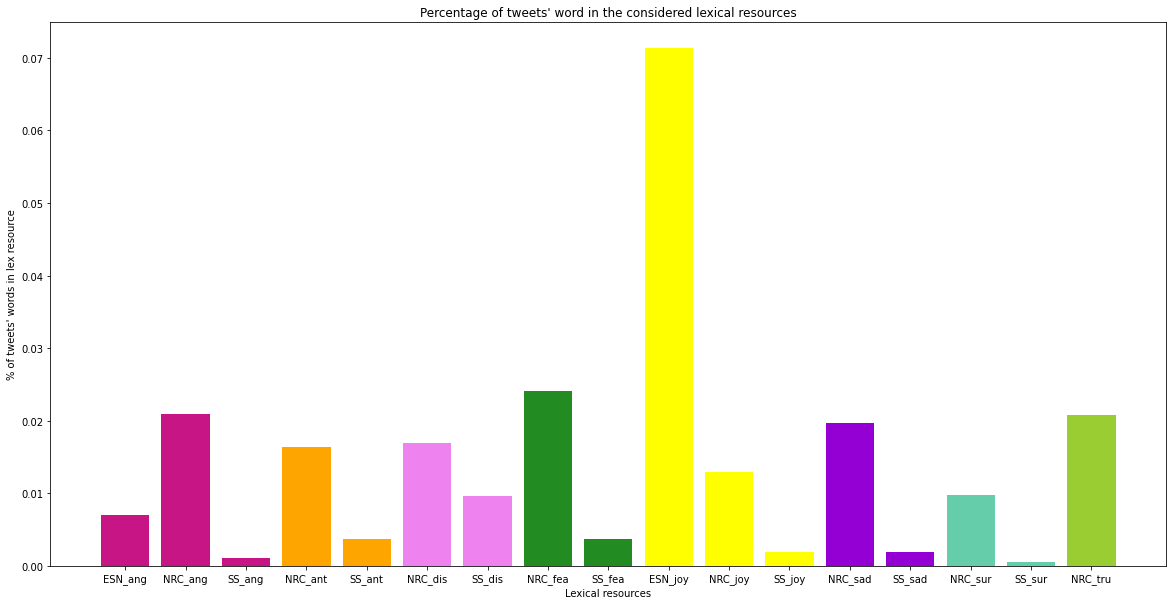

In [44]:
def visualize_tweet_bar_plot(perc_tweet):
    tweet_sent = build_plot_label(perc_tweet.keys())
    colors = build_colors(perc_tweet.keys())
    values = list(perc_tweet.values())
    fig = plt.figure(figsize = (20, 10))
    plt.bar(tweet_sent, values, color=colors)
    plt.xlabel("Lexical resources")
    plt.ylabel("% of tweets' words in lex resource")
    plt.title("Percentage of tweets' word in the considered lexical resources")
    plt.show()

visualize_tweet_bar_plot(PERC_TWEET)

#### Istogramma Risorse Lessicali-Tweet

Il grafico in questione indica la percentuale di parole all'interno delle risorse lessicali, le quali sono state utilizzate all'interno dei tweet. Il tutto viene diviso per ogni documento analizzato.

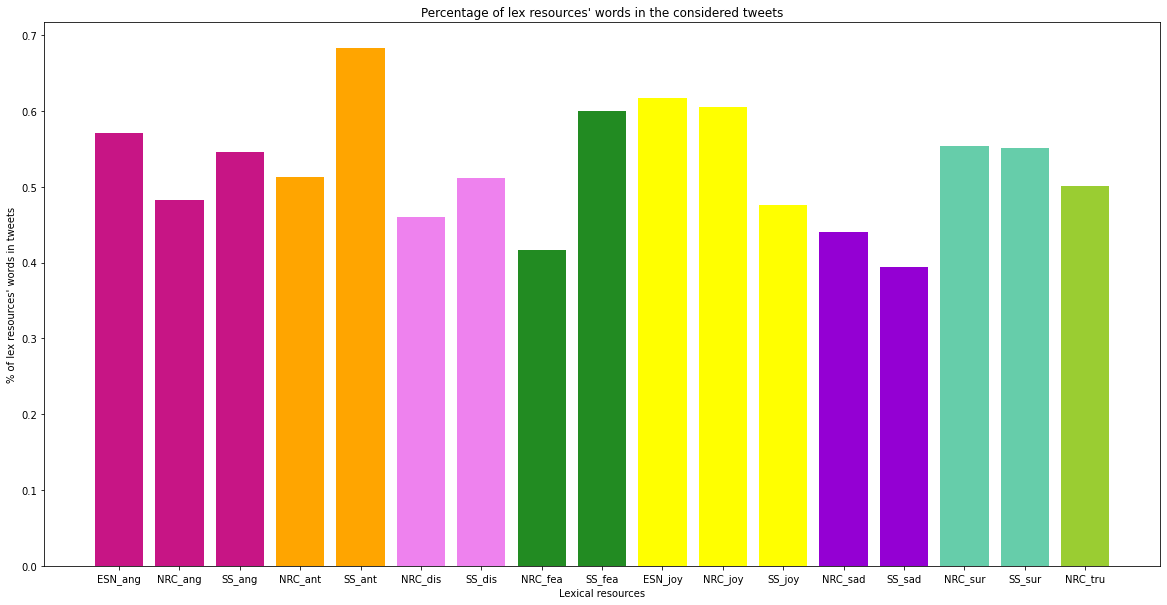

In [45]:
def visualize_lex_res_bar_plot(perc_lex_res):
    tweet_sent = build_plot_label(perc_lex_res.keys())
    colors = build_colors(perc_lex_res.keys())
    values = list(perc_lex_res.values())
    fig = plt.figure(figsize = (20, 10))
    plt.bar(tweet_sent, values, color=colors)
    plt.xlabel("Lexical resources")
    plt.ylabel("% of lex resources' words in tweets")
    plt.title("Percentage of lex resources' words in the considered tweets")
    plt.show()

visualize_lex_res_bar_plot(PERC_LEX_RES)